# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle

from ponyo import utils, train_vae_modules, simulate_expression_data
from generic_expression_patterns_modules import process, calc

np.random.seed(123)

Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "config_pseudomonas.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']
metadata_colname = params['metadata_colname']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_data_file = params['normalized_compendium_data_file']
shared_genes_file = params['shared_genes_file']
scaler_file = params['scaler_transform_file']

### Download Pseudomonas compendium
The compendium is downloaded from https://raw.githubusercontent.com/greenelab/adage/master/Data_collection_processing/Pa_compendium_02.22.2014.pcl

In [4]:
# Read compendium
original_compendium = pd.read_csv(original_compendium_file,
                                  header=0,
                                  index_col=0,
                                  sep="\t")

if original_compendium.shape != (950, 5549):
    original_compendium = original_compendium.T
print(original_compendium.shape)
original_compendium.head()

(950, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,9.620090,10.575783,9.296287,9.870074,8.512268,7.903954,7.039473,10.209826,9.784684,5.485688,...,7.740609,9.730384,10.516061,10.639916,9.746849,5.768592,9.224442,11.512176,12.529719,11.804896
54375-4-05.CEL,9.327996,10.781977,9.169988,10.269239,7.237999,7.663758,6.855194,9.631573,9.404465,5.684067,...,7.127736,9.687607,10.199612,9.457152,9.318372,5.523898,7.911031,10.828271,11.597643,11.268520
AKGlu_plus_nt_7-8-09_s1.CEL,9.368599,10.596248,9.714517,9.487155,7.804147,7.681754,6.714411,9.497601,9.523126,5.766331,...,7.343241,9.717993,10.419979,10.164667,10.305005,5.806817,8.575730,10.858250,12.255953,11.309662
anaerobic_NO3_1.CEL,9.083292,9.897050,8.068471,7.310218,6.723634,7.141148,8.492302,7.740717,7.640251,5.267993,...,7.374740,8.287819,9.437053,8.936576,9.418147,5.956482,7.481406,7.687985,9.205525,9.395773
anaerobic_NO3_2.CEL,8.854901,9.931392,8.167126,7.526595,6.864015,7.154523,8.492109,7.716687,7.268094,5.427256,...,7.425398,8.588969,9.313851,8.684602,9.272818,5.729479,7.699086,7.414436,9.363494,9.424762


### Select template experiment

We manually selected bioproject [E-GEOD-9989](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-9989/?query=George+O%27Toole), which contains 2 samples (3 replicates each) of PA14 WT that are grown on CFBE41o- cells are either treated tobramycin or untreated.

In [5]:
sample_ids = simulate_expression_data.get_sample_ids(project_id, dataset_name, metadata_colname)

In [6]:
# Get samples from experiment id
template_data = original_compendium.loc[sample_ids]
print(template_data.shape)
template_data.head()

(6, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM252496.CEL,9.302014,10.340729,8.509814,8.546586,7.190106,8.098072,7.763456,8.711866,8.231108,5.404296,...,8.287408,8.421579,10.389749,10.196383,9.007465,6.519680,7.809740,10.834743,12.154519,11.469608
GSM252501.CEL,9.227238,10.599580,8.497225,8.441499,7.268252,7.665157,8.333018,8.631129,8.363320,5.333992,...,8.348068,8.778397,10.513588,10.277491,9.080569,5.860684,7.966813,11.191529,12.462472,11.523245
GSM252505.CEL,9.517033,10.339702,8.802129,8.454150,7.423431,7.525809,8.065938,8.697809,8.356419,5.988116,...,7.801774,8.643207,10.474911,10.347455,9.317778,6.276281,7.930625,11.226217,12.401699,11.553060
GSM252506.CEL,8.909442,8.114069,8.078852,7.795723,7.952558,8.077756,8.216912,7.638629,8.158487,5.864669,...,8.689324,6.182037,9.096482,7.042378,8.483629,6.593347,7.235280,8.915381,12.891730,12.143357
GSM252507.CEL,8.672256,8.468489,7.908454,8.186841,7.866482,8.100766,7.874273,7.662463,8.058386,5.589815,...,8.506968,6.612229,8.933697,7.425225,8.922522,5.939707,7.355348,8.662778,12.862123,12.162734


### Normalize compendium 

In [7]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

print(original_data_scaled_df.shape)
original_data_scaled_df.head()

(950, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


### Save data files

In [8]:
# Save data
original_compendium.to_csv(
    original_compendium_file, float_format='%.3f', sep='\t')

template_data.to_csv(template_data_file, float_format='%.5f', sep='\t')

original_data_scaled_df.to_csv(
    normalized_data_file, float_format='%.3f', sep='\t')

# Save scaler transform
outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

# Save shared genes
# In this case all genes are used
shared_genes = list(original_compendium.columns)

outfile = open(shared_genes_file,'wb')
pickle.dump(shared_genes,outfile)
outfile.close()

### Train VAE 

In [9]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

input dataset contains 950 samples and 5549 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 712 samples, validate on 238 samples
Epoch 1/100
712/712 [==============================] - 35s 49ms/step - loss: 3519.7484 - val_loss: 3717.7496
Epoch 2/100
712/712 [==============================] - 35s 50ms/step - loss: 3477.0794 - val_loss: 3538.3401
Epoch 3/100
712/712 [==============================] - 35s 49ms/step - loss: 3465.7806 - val_loss: 3450.9278
Epoch 4/100
712/712 [==============================] - 35s 49ms/step - loss: 3453.0658 - val_loss: 3434.3566
Epoch 5/100
712/712 [==============================] - 35s 49ms/step - loss: 3448.3627 - val_loss: 3428.2914
Epoch 6/100
712/712 [==============================] - 35s 49ms/step - loss: 3436.6796 - val_loss: 3424.8958
Epoch 7/100
712/712 [==============================] - 35s 49ms/step - loss: 3432.6972 - val_loss: 3412.9294
Epoch 8/100
712/712 [==============================] - 35s 49ms/step - loss: 3425.4326 - val_loss: 3413.8871
Epoch 9/100
712/712 [==============================] - 35s 49ms/step - loss: 3418.

712/712 [==============================] - 35s 49ms/step - loss: 3287.2816 - val_loss: 3305.2786
Epoch 76/100
712/712 [==============================] - 35s 49ms/step - loss: 3288.0305 - val_loss: 3300.6409
Epoch 77/100
712/712 [==============================] - 35s 49ms/step - loss: 3286.9100 - val_loss: 3301.5558
Epoch 78/100
712/712 [==============================] - 35s 49ms/step - loss: 3286.0134 - val_loss: 3302.4383
Epoch 79/100
712/712 [==============================] - 35s 49ms/step - loss: 3285.6428 - val_loss: 3301.8189
Epoch 80/100
712/712 [==============================] - 35s 49ms/step - loss: 3284.9586 - val_loss: 3301.6290
Epoch 81/100
712/712 [==============================] - 35s 49ms/step - loss: 3282.2327 - val_loss: 3298.4994
Epoch 82/100
712/712 [==============================] - 35s 49ms/step - loss: 3283.2138 - val_loss: 3304.3385
Epoch 83/100
712/712 [==============================] - 35s 49ms/step - loss: 3284.7941 - val_loss: 3302.2603
Epoch 84/100
712/712 [=

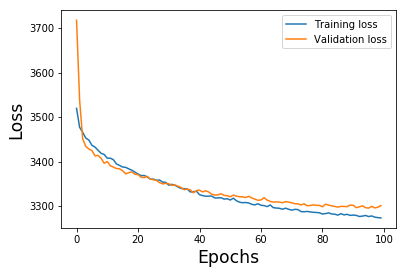

In [10]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_file,
                            normalized_data_file)